# CIS6800: Project 2: YOLO

### Instructions:
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python. PyTorch is required, PyTorch Lightning is recommended but not required.
* You may include any code used in previous projects.
* You are encouraged to use ChatGPT, but you need to make a summary of how you used it, and the code that you have copied from it.


## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you don't need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} =
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} +
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} +
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} +
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} +
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [1]:
!pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import os
import glob
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# device = torch.device("mps")
seed = 17
torch.manual_seed(seed);

The syntax of the command is incorrect.


In [2]:
# download the data
# if this fails, you can download manually and upload to colab
# manual download link: https://drive.google.com/file/d/1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4/view?usp=sharing
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4' -O labels.npz
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1MT-J-hgix3BX7HpUumNQiX5J-By47vt1&confirm=t&uuid=e26a8982-e398-4c5e-974d-1459e3599e6c&at=AB6BwCBY6SHI_fcCMpuRgoG38F7K:1694019172385' -O images.npz

In [102]:
def load_data(file_name):
    # Use this function to import the provided data files
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

import traceback
try:
    images = load_data('./images.npz')
    raw_labels = load_data('./labels.npz')
except Exception as e:
    print(e)
    traceback.print_exc()
    print("load failed, maybe manual download")

In [103]:
def process_labels(raw_labels):
    # This function should compute the 8X8X8 label from the raw labels for the corresponding image.
    # raw_lables: shape (N_image, (N_box, 5))

    image_width = 128
    image_height = 128
    grid_xnum = 8
    grid_ynum = 8
    grid_width = image_width / grid_xnum # 16
    grid_height = image_height / grid_ynum # 16

    def get_grid_index(x1, y1, x2, y2):
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        grid_x = int(cx / (image_width / grid_xnum))
        grid_y = int(cy / (image_height / grid_ynum))
        return (grid_x, grid_y)

    labels = np.zeros((raw_labels.shape[0], 8, 8, 8), dtype=np.float64)
    for img_i in range(raw_labels.shape[0]):
        for box_i in range(raw_labels[img_i].shape[0]):
            raw_label = raw_labels[img_i][box_i]
            class_id = int(raw_label[0])
            x1 = raw_label[1]
            y1 = raw_label[2]
            x2 = raw_label[3]
            y2 = raw_label[4]
            label = labels[img_i]
            (grid_x, grid_y) = get_grid_index(x1, y1, x2, y2)

            # if label[0, grid_x, grid_y] == 1:
            #     # print(f"Warning: grid cell {grid_x}, {grid_y} already has an object")
            #     continue
            Pr = 1 if class_id in [0, 1, 2] else 0
            if Pr == 0:
                # print(f"Warning: class_id {class_id} is not in [0, 1, 2]")
                continue

            box_x = (((x1 + x2) / 2) % grid_width) / grid_width
            box_y = (((y1 + y2) / 2) % grid_height) / grid_height
            box_w = (x2 - x1) / image_width
            box_h = (y2 - y1) / image_height
            
            label[0, grid_x, grid_y] = Pr
            label[1, grid_x, grid_y] = box_x
            label[2, grid_x, grid_y] = box_y
            label[3, grid_x, grid_y] = box_w
            label[4, grid_x, grid_y] = box_h
            label[5:8, grid_x, grid_y] = 0  # set 5,6,7 to zero first
            label[5 + class_id, grid_x, grid_y] = 1  # one-hot encoding

    return labels # [N_image, 8, 8, 8]

# labels = process_labels(raw_labels)
# print(f"label example: {labels[0]}")
# print(f"labels shape: {labels.shape}")
# print(f"raw_labels shape: {raw_labels.shape}, {raw_labels[1].shape}")

In [104]:
def reconstruct_raw_labels(labels, img_dim=128, include_score=False):
    # This function should perform the inverse operation of process_labels().
    # labels: [N_image, 8, 8, 8]

    grid_xnum = 8
    grid_ynum = 8
    grid_width = img_dim / grid_xnum  # 16
    grid_height = img_dim / grid_ynum  # 16
    raw_labels = []
    
    for img_i in range(labels.shape[0]):
        boxes = []
        for grid_x in range(8):
            for grid_y in range(8):
                label = labels[img_i]
                conf = label[0, grid_x, grid_y]
                if conf > 0:
                    box_x = (grid_x + label[1, grid_x, grid_y]) * grid_width
                    box_y = (grid_y + label[2, grid_x, grid_y]) * grid_height
                    box_w = label[3, grid_x, grid_y] * img_dim
                    box_h = label[4, grid_x, grid_y] * img_dim
                    x1 = box_x - (box_w / 2)
                    y1 = box_y - (box_h / 2)
                    x2 = box_x + (box_w / 2)
                    y2 = box_y + (box_h / 2)

                    class_id = np.argmax(
                        label[5:, grid_x, grid_y]
                    ) 
                    if include_score:
                        boxes.append(
                            np.array([class_id, conf, x1, y1, x2, y2], dtype=np.float64)
                        )
                    else:
                        boxes.append(
                            np.array([class_id, x1, y1, x2, y2], dtype=np.float64)
                        )

        raw_labels.append(np.array(boxes))

    return raw_labels
    # return np.array(raw_labels, dtype=object)

    # if include_score:
    #     return raw_labels # shape (N_image, (N_box, 6)); class, score, x1, y1, x2, y2
    # else:
    #     return raw_labels # shape (N_image, (N_box, 5)); class, x1, y1, x2, y2

# labels = process_labels(raw_labels)
# # print(f"labels shape: {labels.shape}")
# # print(f"raw_labels shape: {raw_labels.shape}, {raw_labels[1].shape}")
# print(f"first raw label:\n{raw_labels[1]}")
# new_raw_labels = reconstruct_raw_labels(labels, include_score=False)
# # print(f"labels shape: {labels.shape}")
# # print(f"new_raw_labels shape: {new_raw_labels.shape}, {new_raw_labels[1].shape}")
# print(f"first new raw label: \n{new_raw_labels[1]}")

In [105]:
def yolo_loss(output, target):
    
    def calculate_iou(
        pred_x, pred_y, pred_w, pred_h, target_x, target_y, target_w, target_h
    ):
        image_width = 128
        image_height = 128
        grid_xnum = 8
        grid_ynum = 8
        grid_width = image_width / grid_xnum  # 16
        grid_height = image_height / grid_ynum  # 16

        iou = torch.zeros_like(pred_x)

        for grid_x in range(grid_xnum):
            for grid_y in range(grid_ynum):
                # Predicted bounding box
                local_pred_x = pred_x[:, grid_x, grid_y] * grid_width + (
                    grid_x * grid_width
                )
                local_pred_y = pred_y[:, grid_x, grid_y] * grid_height + (
                    grid_y * grid_height
                )
                local_pred_w = pred_w[:, grid_x, grid_y] * image_width
                local_pred_h = pred_h[:, grid_x, grid_y] * image_height

                # Target bounding box
                local_target_x = target_x[:, grid_x, grid_y] * grid_width + (
                    grid_x * grid_width
                )
                local_target_y = target_y[:, grid_x, grid_y] * grid_height + (
                    grid_y * grid_height
                )
                local_target_w = target_w[:, grid_x, grid_y] * image_width
                local_target_h = target_h[:, grid_x, grid_y] * image_height

                # Calculate corners of the predicted bounding box
                pred_x1 = local_pred_x - local_pred_w / 2
                pred_y1 = local_pred_y - local_pred_h / 2
                pred_x2 = local_pred_x + local_pred_w / 2
                pred_y2 = local_pred_y + local_pred_h / 2

                # Calculate corners of the target bounding box
                target_x1 = local_target_x - local_target_w / 2
                target_y1 = local_target_y - local_target_h / 2
                target_x2 = local_target_x + local_target_w / 2
                target_y2 = local_target_y + local_target_h / 2

                # Intersection area
                inter_x1 = torch.max(pred_x1, target_x1)
                inter_y1 = torch.max(pred_y1, target_y1)
                inter_x2 = torch.min(pred_x2, target_x2)
                inter_y2 = torch.min(pred_y2, target_y2)
                inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(
                    inter_y2 - inter_y1, min=0
                )

                # Union area
                pred_area = local_pred_w * local_pred_h
                target_area = local_target_w * local_target_h
                union_area = pred_area + target_area - inter_area

                # Calculate IoU and assign to the correct location in the tensor
                iou[:, grid_x, grid_y] = inter_area / torch.clamp(union_area, min=10e-10)

        return iou

    
    # output: [B, 8, 8, 8]
    # target: [B, 8, 8, 8]

    lambda_coord = 5
    lambda_noobj = 0.5

    # Extract components from the output
    pred_conf = output[:, 0, :, :]  # Pr(Objectness)
    pred_x = output[:, 1, :, :]  # x-coordinate
    pred_y = output[:, 2, :, :]  # y-coordinate
    pred_w = output[:, 3, :, :]  # width
    pred_h = output[:, 4, :, :]  # height
    pred_class_probs = output[:, 5:, :, :]  # class probabilities

    # Extract components from the target
    target_pr = target[:, 0, :, :]  # Pr(Objectness)
    target_x = target[:, 1, :, :]  # x-coordinate
    target_y = target[:, 2, :, :]  # y-coordinate
    target_w = target[:, 3, :, :]  # width
    target_h = target[:, 4, :, :]  # height
    target_class_probs = target[:, 5:, :, :]  # class probabilities

    iou = calculate_iou(
        pred_x, pred_y, pred_w, pred_h, target_x, target_y, target_w, target_h
    )

    pred_confidence = pred_conf
    target_confidence = target_pr * iou

    # Object mask (1 if there's an object in the cell, 0 otherwise)
    obj_mask = target_pr > 0

    # Coordinate loss: (x_i - x̂_i)^2 + (y_i - ŷ_i)^2
    coord_loss = lambda_coord * torch.sum(
        obj_mask * ((pred_x - target_x) ** 2 + (pred_y - target_y) ** 2)
    )

    # Size loss: (sqrt(w_i) - sqrt(ŵ_i))^2 + (sqrt(h_i) - sqrt(ĥ_i))^2
    size_loss = lambda_coord * torch.sum(
        obj_mask
        * (
            (torch.sqrt(pred_w) - torch.sqrt(target_w)) ** 2
            + (torch.sqrt(pred_h) - torch.sqrt(target_h)) ** 2
        )
    )

    # Confidence loss for cells containing objects: (C_i - Ĉ_i)^2
    confidence_loss_obj = torch.sum(
        obj_mask * ((pred_confidence - target_confidence) ** 2)
    )

    # Confidence loss for cells not containing objects: λ_noobj * (C_i - Ĉ_i)^2
    confidence_loss_noobj = lambda_noobj * torch.sum(
        ~obj_mask * ((pred_confidence - target_confidence) ** 2)
    )

    # Classification loss: Σ(p_i(c) - p̂_i(c))^2 for each class
    internal_sum = torch.sum((pred_class_probs - target_class_probs) ** 2, dim=1)
    class_loss = torch.sum(obj_mask * internal_sum)

    # Total loss
    loss = (
        coord_loss
        + size_loss
        + confidence_loss_obj
        + confidence_loss_noobj
        + class_loss
    )

    # print(f"confidence_loss_obj: {confidence_loss_obj}")
    # print(f"confidence_loss_noobj: {confidence_loss_noobj}")

    return loss

# output = torch.tensor(
#     [
#         [
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.4710, 0.6072, 0.5723, 0.6092, 0.6704, 0.6269, 0.5893, 0.4824],
#                 [0.4549, 0.5034, 0.5145, 0.4357, 0.5343, 0.4648, 0.6084, 0.3998],
#                 [0.4864, 0.5460, 0.5015, 0.5607, 0.3940, 0.3640, 0.5748, 0.3943],
#                 [0.4821, 0.4927, 0.5297, 0.5596, 0.5123, 0.5113, 0.6711, 0.4368],
#                 [0.4427, 0.4697, 0.4405, 0.5814, 0.3995, 0.4463, 0.4343, 0.4237],
#                 [0.4416, 0.5209, 0.5177, 0.4852, 0.3490, 0.4016, 0.5378, 0.3529],
#                 [0.4770, 0.5672, 0.5207, 0.5655, 0.3860, 0.3776, 0.5086, 0.4417],
#                 [0.5198, 0.5346, 0.5729, 0.5769, 0.4868, 0.3881, 0.6073, 0.4800],
#             ],
#             [
#                 [0.4731, 0.6550, 0.5471, 0.6601, 0.3665, 0.4378, 0.3071, 0.4853],
#                 [0.6514, 0.6865, 0.5027, 0.6273, 0.5626, 0.2267, 0.3209, 0.5714],
#                 [0.6475, 0.7043, 0.5533, 0.6639, 0.4114, 0.1562, 0.2752, 0.5338],
#                 [0.6750, 0.6858, 0.4576, 0.6673, 0.1967, 0.0486, 0.2713, 0.6026],
#                 [0.5733, 0.5129, 0.5634, 0.6150, 0.0409, 0.0247, 0.3518, 0.4103],
#                 [0.6153, 0.5457, 0.5854, 0.5205, 0.0422, 0.0000, 0.5541, 0.4533],
#                 [0.6375, 0.5675, 0.7594, 0.4398, 0.1202, 0.1731, 0.5819, 0.3481],
#                 [0.5889, 0.6236, 0.7664, 0.4053, 0.0765, 0.2789, 0.7229, 0.3714],
#             ],
#             [
#                 [0.0535, 0.0421, 0.0745, 0.1202, 0.1561, 0.1731, 0.2306, 0.1247],
#                 [0.0614, 0.0317, 0.1306, 0.2413, 0.3995, 0.4415, 0.2956, 0.1278],
#                 [0.0608, 0.0204, 0.1612, 0.3003, 0.5332, 0.5145, 0.2999, 0.2196],
#                 [0.0671, 0.0354, 0.1749, 0.2854, 0.4668, 0.4303, 0.1787, 0.1135],
#                 [0.0588, 0.0195, 0.1434, 0.2236, 0.2826, 0.2925, 0.0816, 0.1330],
#                 [0.0305, 0.0400, 0.1009, 0.1407, 0.2687, 0.3298, 0.1269, 0.1148],
#                 [0.0219, 0.0184, 0.0654, 0.1009, 0.1970, 0.2821, 0.0520, 0.1064],
#                 [0.0309, 0.0365, 0.0504, 0.0575, 0.1039, 0.1827, 0.0271, 0.0421],
#             ],
#             [
#                 [0.1483, 0.1233, 0.1147, 0.2118, 0.3190, 0.4160, 0.3401, 0.1784],
#                 [0.1346, 0.1341, 0.1848, 0.2633, 0.4778, 0.5645, 0.3878, 0.0235],
#                 [0.0965, 0.0888, 0.1743, 0.2975, 0.4588, 0.5430, 0.4250, 0.0982],
#                 [0.0864, 0.1165, 0.2080, 0.2850, 0.3736, 0.4497, 0.2484, 0.0602],
#                 [0.0909, 0.1196, 0.1556, 0.2205, 0.3105, 0.3374, 0.3549, 0.0491],
#                 [0.0885, 0.1000, 0.1543, 0.1696, 0.3253, 0.3608, 0.2899, 0.0000],
#                 [0.0720, 0.1048, 0.0972, 0.1255, 0.3590, 0.3688, 0.2379, 0.0000],
#                 [0.0681, 0.0982, 0.0844, 0.1007, 0.3003, 0.1582, 0.1058, 0.0123],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.2073, 0.0920, 0.3921, 0.6785, 0.8854, 1.0041, 0.5697, 0.0000],
#                 [0.0000, 0.0000, 0.2896, 0.7070, 1.0204, 1.2740, 0.0078, 0.0000],
#                 [0.0000, 0.0000, 0.4493, 0.8128, 1.0732, 1.2959, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.4880, 0.7934, 0.9858, 0.8676, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.4068, 0.8133, 0.8653, 0.7060, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.4122, 0.7655, 0.7866, 0.5438, 0.0000, 0.0065],
#                 [0.0000, 0.0000, 0.3923, 0.7899, 0.6031, 0.5418, 0.0793, 0.0698],
#                 [0.0327, 0.0000, 0.5807, 0.8887, 0.6592, 0.2484, 0.2237, 0.3623],
#             ],
#         ]
#     ]
# )

# target = torch.tensor(
#     [
#         [
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.9375, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.9375, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.3438, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.8125, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.7812, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.6562, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.5312, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.4375, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.3750, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.2812, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.2969, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.3047, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0781, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0234, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.2656, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.1953, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.1641, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0859, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0781, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#             [
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#                 [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
#             ],
#         ]
#     ]
# )

# print(yolo_loss(output, target)) # Expected: 8.570581436157227

# Part B

In [106]:
def precision_recall_curve(predictions, targets, target_class):
    # helpful video: https://www.youtube.com/watch?v=QdWidmgLwbw
    # predictions: shape (N_image, (N_box, 6)); class, score, x1, y1, x2, y2
    #   inner array of prediction (N_box, 6) is be `None` if nothing predicted
    # targets: shape (N_image, (N_box, 5)); class, x1, y1, x2, y2

    def iou(box1, box2):
        # box format: [x1, y1, x2, y2]
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        inter_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
        box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
        box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area

    iou_threshold=0.5
    filtered_predictions = []
    filtered_targets = []

    for img_i in range(len(predictions)):
        if  predictions[img_i] is None:
            continue
        ps = [pred for pred in predictions[img_i] if pred[0] == target_class]
        ts = [tgt for tgt in targets[img_i] if tgt[0] == target_class]
        for p in ps:
            pred_box = p[2:]
            matched = False
            for t in ts:
                target_box = t[1:]
                if iou(pred_box, target_box) > iou_threshold:
                    p = np.append(p, 1)
                    matched = True
                    break
            if not matched:
                p = np.append(p, 0)
            filtered_predictions.append(p)
        filtered_targets.extend(ts)

    sorted_predictions = sorted(filtered_predictions, key=lambda x: x[1], reverse=True)
    true_positives = np.array(
        [pred[6] == 1 for pred in sorted_predictions], dtype=np.float32
    )
    false_positives = 1 - true_positives
    acc_true_positives = np.cumsum(true_positives)
    acc_false_positives = np.cumsum(false_positives)
    if len(filtered_targets) == 0:
        recall = np.zeros_like(acc_true_positives)
    else:
        recall = acc_true_positives / len(filtered_targets)
    precision = acc_true_positives / (acc_true_positives + acc_false_positives)

    return recall, precision

def average_precision(predictions, targets, target_class):
    # predictions: shape (N_image, (N_box, 6)); class, score, x1, y1, x2, y2
    #   inner array of prediction (N_box, 6) is be `None` if nothing predicted
    # targets: shape (N_image, (N_box, 5)); class, x1, y1, x2, y2

    recall, precision = precision_recall_curve(
        predictions, targets, target_class
    )

    recall = np.concatenate((recall, [1]))
    precision = np.concatenate((precision, [0]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    indices = np.where(recall[1:] != recall[:-1])[0]

    area = []
    r1 = 0
    for i in range(len(indices)):
        r2 = recall[indices[i]]
        p = precision[indices[i]]
        if i != 0:
            area.append(p * (r2 - r1))
        # print(f"idx: {indices[i]}, r1: {r1}, r2: {r2}, p: {p}, area: {area}")
        r1 = r2
    average_precision = np.sum(area)

    return average_precision

def mean_average_precision(predictions, targets):
    # predictions: shape (N_image, (N_box, 6)); class, score, x1, y1, x2, y2
    #   inner array of prediction (N_box, 6) is be `None` if nothing predicted
    # targets: shape (N_image, (N_box, 5)); class, x1, y1, x2, y2

    # print(f"predictions: {predictions}")
    # print(f"targets: {targets}")
    average_precisions = []
    num_classes = 3
    for c in range(num_classes):
        ap = average_precision(predictions, targets, c)
        average_precisions.append(ap)

    mean_average_precision = np.mean(average_precisions) if len(average_precisions) > 0 else 0
    return mean_average_precision # float


# predictions = [
#     (
#         [
#             [2.0, 0.81193191, -0.53667212, 49.8775425, 10.54487276, 66.31215286],
#             [0.0, 0.64093781, 16.49726486, 51.58106756, 22.0256424, 63.44743586],
#             [2.0, 0.81821513, 39.99876213, 41.72924995, 69.74138641, 63.2180233],
#             [0.0, 0.60132337, 80.5998944, 49.92964077, 83.9149791, 58.57145309],
#             [2.0, 0.66413248, 95.08378983, 51.65060425, 103.43097591, 60.65379524],
#             [2.0, 0.84017855, 99.83577442, 46.53772354, 129.29212856, 71.88980103],
#         ]
#     ),
#     (
#         [
#             [2.0, 0.73652303, 104.41268063, 52.35053587, 114.29913044, 66.37933588],
#             [0.0, 0.68063837, 114.80239153, 49.73365402, 121.98486471, 64.19790459],
#             [2.0, 0.88727057, 26.46716022, 47.74527073, 80.4569521, 90.33987522],
#             [2.0, 0.66911352, 74.47404385, 51.03989661, 97.04666042, 78.32730734],
#         ]
#     ),
#     (
#         [
#             [2.0, 0.82470232, -0.38514233, 49.20405722, 30.71822071, 60.59038019],
#             [2.0, 0.69705886, 35.85675454, 48.67209411, 43.85173774, 53.80656791],
#             [2.0, 0.75573903, 93.87241793, 45.80860543, 108.19608355, 55.72925305],
#         ]
#     ),
#     # ([[2.0, 0.72592711, 94.43713236, 45.61507583, 108.00636625, 55.51472735]]),
#     None
# ]
# targets = [
#     (
#         [
#             [2.0, 93.0, 53.0, 98.0, 58.0],
#             [2.0, 101.0, 47.0, 128.0, 72.0],
#             [0.0, 81.0, 52.0, 84.0, 58.0],
#             [2.0, 98.0, 52.0, 104.0, 61.0],
#             [2.0, 40.0, 44.0, 69.0, 62.0],
#             [2.0, 0.0, 50.0, 9.0, 66.0],
#             [0.0, 16.0, 53.0, 21.0, 63.0],
#         ]
#     ),
#     (
#         [
#             [2.0, 73.0, 53.0, 98.0, 77.0],
#             [2.0, 89.0, 51.0, 110.0, 71.0],
#             [0.0, 116.0, 50.0, 121.0, 64.0],
#             [2.0, 30.0, 49.0, 78.0, 90.0],
#             [2.0, 106.0, 53.0, 114.0, 67.0],
#         ]
#     ),
#     (
#         [
#             [2.0, 27.0, 48.0, 38.0, 55.0],
#             [2.0, 37.0, 48.0, 45.0, 54.0],
#             [2.0, 0.0, 49.0, 31.0, 61.0],
#             [2.0, 94.0, 47.0, 109.0, 55.0],
#         ]
#     ),
#     (
#         [
#             [2.0, 121.0, 48.0, 128.0, 72.0],
#             [0.0, 108.0, 49.0, 114.0, 58.0],
#             [2.0, 117.0, 50.0, 122.0, 55.0],
#             [0.0, 120.0, 49.0, 124.0, 58.0],
#             [2.0, 96.0, 45.0, 106.0, 57.0],
#         ]
#     ),
# ]

# new_predictions = []
# for p in predictions:
#     if p is None:
#         new_predictions.append(None)
#     else:
#         new_predictions.append(np.array(p))
# predictions = new_predictions
# targets = [np.array(t) for t in targets]

# recall, precision = precision_recall_curve(predictions, targets, 2)

# plt.figure()
# plt.plot(recall, precision)
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall curve")
# plt.show()

# ap = average_precision(predictions, targets, 2)
# print(f"AP for class 2: {ap}")  # Expected: 0.69

# mAP = mean_average_precision(predictions, targets)
# print(f"mAP: {mAP}") # Expected: 0.34

In [ ]:
class YOLO(pl.LightningModule):

    def __init__(self):
        self.mAPs = []
        self.train_losses = []
        self.val_losses = []

        super().__init__()
        k_size = 4
        self.conv1 = nn.Conv2d(3, 32, kernel_size=k_size, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, k_size, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, k_size, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, k_size, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, k_size, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, k_size, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.trans_conv7 = nn.ConvTranspose2d(1024, 256, k_size, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.trans_conv8 = nn.ConvTranspose2d(256, 64, k_size, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(64)
        self.conv9 = nn.Conv2d(64, 8, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        c1 = F.relu(self.bn1(self.conv1(x)))
        c2 = F.relu(self.bn2(self.conv2(c1)))
        c3 = F.relu(self.bn3(self.conv3(c2)))
        c4 = F.relu(self.bn4(self.conv4(c3)))
        c5 = F.relu(self.bn5(self.conv5(c4)))
        c6 = F.relu(self.bn6(self.conv6(c5)))
        c7 = F.relu(self.bn7(self.trans_conv7(c6)))
        c8 = F.relu(self.bn8(self.trans_conv8(c7)))
        c9 = self.conv9(c8)

        objectness_and_box = torch.sigmoid(c9[:, :5, :, :])
        class_probs = torch.softmax(c9[:, 5:, :, :], dim=1)
        output = torch.cat([objectness_and_box, class_probs], dim=1)

        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = yolo_loss(y_hat, y)
        # print(f"\nLabel: {y[0,0,0,:8]}\nOutput: {y_hat[0,0,0,:8]}")

        assert torch.all(y_hat >= 0), "y_hat contains negative value"
        assert torch.all(y_hat <= 1), "y_hat contains value greater than 1"
        assert not torch.any(torch.isnan(y_hat)), "y_hat contains nan"
        assert torch.all(y >= 0), "y contains negative value"
        assert torch.all(y <= 1), "y contains value greater"
        assert not torch.any(torch.isnan(y)), "y contains nan"

        y_reconstructed = reconstruct_raw_labels(y.cpu().squeeze().detach().numpy())
        y_hat_reconstructed = reconstruct_raw_labels(
            y_hat.cpu().squeeze().detach().numpy(), include_score=True
        )
        mAP = mean_average_precision(y_hat_reconstructed, y_reconstructed)

        if not torch.isnan(torch.tensor(mAP)):
            self.mAPs.append(mAP)
            self.log("train_mAP", mAP, on_step=True, prog_bar=True)
        if not torch.isnan(loss):
            self.train_losses.append(loss)
            self.log("train_loss", loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = yolo_loss(y_hat, y)
        self.val_losses.append(loss)
        self.log("val_loss", loss, prog_bar=True)

    def on_train_epoch_end(self):
        avg_train_loss = torch.tensor(self.train_losses).mean()
        avg_mAP = torch.tensor(self.mAPs).mean()
        self.log("avg_train_loss_per_epoch", avg_train_loss)
        self.log("avg_train_mAP_per_epoch", avg_mAP)
        self.train_losses = []
        self.mAPs = []

    def on_validation_epoch_end(self):
        avg_val_loss = torch.tensor(self.val_losses).mean()
        self.log("avg_val_loss_per_epoch", avg_val_loss)
        self.val_losses = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
           optimizer=optimizer, milestones=[40, 80], gamma=0.5
        )
        return {"optimizer": optimizer, "lr_scheduler":
            {
            "scheduler": scheduler,
            "interval": "epoch",
            "frequency": 1
            }
        }

In [115]:
def low_confidence_suppression(label):
    # label shape: (N_box, 6) class, score, x1, y1, x2, y2
    confidence_threshold = 0.6
    
    filtered_labels = []
    for i in range(label.shape[0]):
        if label[i][1] > confidence_threshold:
            filtered_labels.append(label[i])
    label = np.array(filtered_labels)
    
    return label

def get_iou_matrix(bbox_a, bbox_b):
    # bbox_a: (N, 4) 4: x1, y1, x2, y2
    # bbox_b: (M, 4) 4: x1, y1, x2, y2
    N = bbox_a.shape[0]
    M = bbox_b.shape[0]
    iou_matrix = np.zeros((N, M))

    for i in range(N):
        for j in range(M):
            x1 = max(bbox_a[i][0], bbox_b[j][0])
            y1 = max(bbox_a[i][1], bbox_b[j][1])
            x2 = min(bbox_a[i][2], bbox_b[j][2])
            y2 = min(bbox_a[i][3], bbox_b[j][3])

            inter_area = max(0, x2 - x1) * max(0, y2 - y1)
            union_area = (
                (bbox_a[i][2] - bbox_a[i][0]) * (bbox_a[i][3] - bbox_a[i][1])
                + (bbox_b[j][2] - bbox_b[j][0]) * (bbox_b[j][3] - bbox_b[j][1])
                - inter_area
            )
            iou_matrix[i][j] = inter_area / union_area

    return iou_matrix

def non_max_suppression(label):
    # label shape: (N_box, 6) class, score, x1, y1, x2, y2
    filtered_labels = []
    iou_threshold = 0.5

    preds = label
    sorted_preds = preds[preds[:, 1].argsort()[::-1]]

    bbox_a = sorted_preds[:, 2:]
    bbox_b = sorted_preds[:, 2:]
    iou_matrix = get_iou_matrix(bbox_a, bbox_b)

    for i in range(len(sorted_preds)):
        box1 = sorted_preds[i]
        class1 = box1[0]
        if box1[1] == 0:
            continue
        filtered_labels.append(box1)
        for j in range(i+1, len(sorted_preds)):
            box2 = sorted_preds[j]
            class2 = box2[0]
            if iou_matrix[i][j] > iou_threshold and class2 == class1:
                box2[1] = 0

    return filtered_labels


# label = np.array([
#             [2.0, 0.81193191, -0.53667212, 49.8775425, 10.54487276, 66.31215286],
#             [0.0, 0.64093781, 16.49726486, 51.58106756, 22.0256424, 63.44743586],
#             [2.0, 0.81821513, 39.99876213, 41.72924995, 69.74138641, 63.2180233],
#             [0.0, 0.60132337, 80.5998944, 49.92964077, 83.9149791, 58.57145309],
#             [2.0, 0.66413248, 95.08378983, 51.65060425, 103.43097591, 60.65379524],
#             [2.0, 0.84017855, 99.83577442, 46.53772354, 129.29212856, 71.88980103],
#         ])
# filtered_label = non_max_suppression(label)
# print(filtered_label)

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
   1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
   2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
   3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

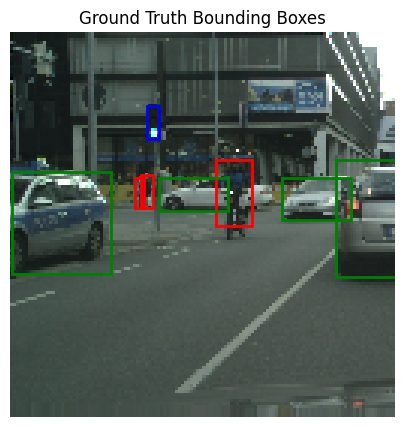

In [116]:
def visualize_image(labels, img, new_figure=True):
    # Show the chosen image with ground truth bounding boxes visualized.
    
    if new_figure: plt.figure(figsize=(5, 5))
    plt.imshow(img)
    ax = plt.gca()
    color_map = {0: "red", 1: "blue", 2: "green"}

    for label in labels:
        if len(label) == 5:
            class_id, x1, y1, x2, y2 = label
        else:
            class_id, score, x1, y1, x2, y2 = label
        class_id = int(class_id)
        color = color_map.get(class_id, "yellow")
        class_names = {0: "Pedestrian", 1: "Traffic Light", 2: "Car"}
        class_name = class_names.get(class_id, "Unknown")

        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2
        )
        ax.add_patch(rect)
        # ax.text(
        #     x1,
        #     y1,
        #     f"{class_id}: {class_name}",
        #     color=color,
        #     fontsize=12,
        #     verticalalignment="top",
        # )
    plt.axis("off")
    # plt.show()

# selected_index = 8
# selected_image = images[selected_index]
# selected_labels = raw_labels[selected_index]
# visualize_image(selected_labels, selected_image)
# plt.title("Ground Truth Bounding Boxes")
# plt.show()

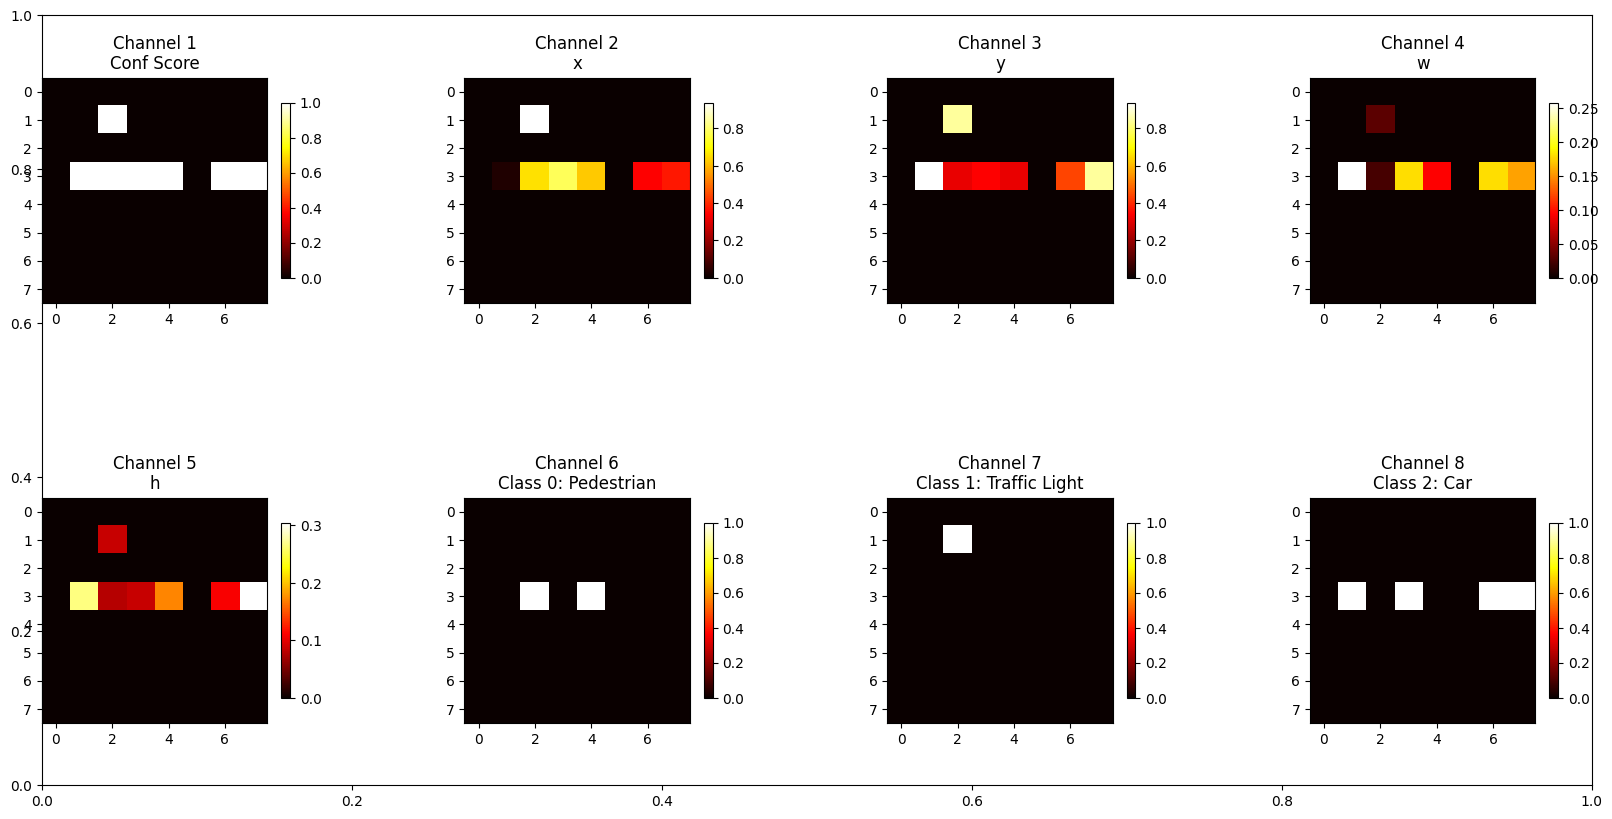

In [117]:
def visualize_8x8x8(label, title=""):
    # Visualize the 8x8x8 representation.
    
    channel_labels = ["Conf Score", "x", "y", "w", "h", "Class 0: Pedestrian", "Class 1: Traffic Light", "Class 2: Car"]
    
    plt.figure(figsize=(20, 10))
    plt.title(title)
    for channel_index in range(8):
        plt.subplot(2, 4, channel_index + 1)
        plt.subplots_adjust(wspace=0.5)
        # print(f"Channel {channel_index + 1}: {label[channel_index]}")
        new_label = np.transpose(label[channel_index])
        plt.imshow(new_label, cmap='hot', interpolation='nearest')
        plt.title(f"Channel {channel_index + 1}\n{channel_labels[channel_index]}")        
        plt.colorbar(shrink=0.5)


# processed_labels = process_labels(np.array([selected_labels]))[0]
# visualize_8x8x8(processed_labels)

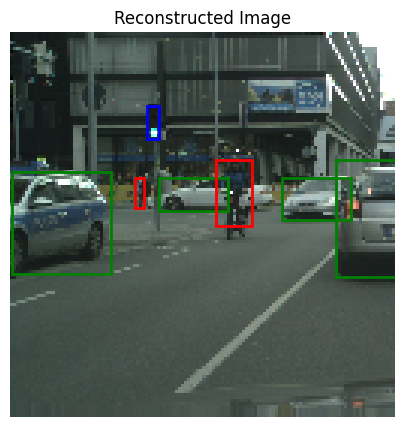

In [118]:
# Convert back to the original representation (test cases below should pass).

# reconstructed_labels = reconstruct_raw_labels(np.array([processed_labels]))[0]
# visualize_image(reconstructed_labels, selected_image)
# plt.title("Reconstructed Image")
# plt.show()

2. Implement the loss function. (3%)

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

<div><img src="https://github.com/Carperis/machine_perception/raw/main/P2%20YOLO/code_architecture.jpg"/></div>

In [119]:
class YOLODataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        result_image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        result_label = torch.tensor(label, dtype=torch.float32)
        return result_image, result_label

def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.ckpt"))
    if not checkpoint_files:
        return None
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    return latest_checkpoint

In [121]:
def train():
    # Train your model

    print(f"Using device: {device}")
    checkpoint_dir = "checkpoints/"
    os.makedirs(checkpoint_dir, exist_ok=True)

    model = YOLO()
    tb_logger = pl_loggers.TensorBoardLogger("logs/")
    
    checkpoint_callback = pl_callbacks.ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename="yolo-{epoch:02d}-{train_loss:.2f}",
        save_top_k=-1,
        # save_weights_only=True,
        monitor="train_loss",
        mode="min",
    )

    # Early stopping callback
    # early_stopping = pl_callbacks.EarlyStopping(
    #     monitor="val_loss", patience=10, mode="min", verbose=True
    # )

    trainer = pl.Trainer(
        accelerator=device.type,
        devices=1 if device.type != "cpu" else None,
        max_epochs=100,
        logger=tb_logger,
        callbacks=[
            checkpoint_callback, 
            # early_stopping
        ],
    )

    labels = process_labels(raw_labels)
    full_dataset = YOLODataset(images, labels)
    val_split_ratio = 0.2
    val_size = int(len(full_dataset) * val_split_ratio)
    train_size = len(full_dataset) - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(17),
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset, batch_size=32,
    )

    latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print(f"Resuming training from checkpoint: {latest_checkpoint}")
        trainer.fit(
            model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader,
            ckpt_path=latest_checkpoint,
        )
    else:
        print("No checkpoint found. Starting training from scratch.")
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using device: cuda:0


Restoring states from the checkpoint path at checkpoints\yolo-epoch=99-train_loss=1.10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type            | Params | Mode 
---------------------------------------------------------
0  | conv1       | Conv2d          | 1.6 K  | train
1  | bn1         | BatchNorm2d     | 64     | train
2  | conv2       | Conv2d          | 32.8 K | train
3  | bn2         | BatchNorm2d     | 128    | train
4  | conv3       | Conv2d          | 131 K  | train
5  | bn3         | BatchNorm2d     | 256    | train
6  | conv4       | Conv2d          | 524 K  | train
7  | bn4         | BatchNorm2d     | 512    | train
8  | conv5       | Conv2d          | 2.1 M  | train
9  | bn5         | BatchNorm2d     | 1.0 K  | train
10 | conv6       | Conv2d          | 8.4 M  | train
11 | bn6         | BatchNorm2d     | 2.0 K  | train
12 | trans_conv7 | ConvTranspose2d | 4.2 M  | train
13 | bn7         | BatchNorm2d     | 512    | train
14 | trans_conv8 | ConvTran

Resuming training from checkpoint: checkpoints\yolo-epoch=99-train_loss=1.10.ckpt
                                                                           

`Trainer.fit` stopped: `max_epochs=100` reached.


4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%)

5. Show a plot of the mean Average Precision over training for your model. (10%)

Using log folder: logs/lightning_logs/version_40


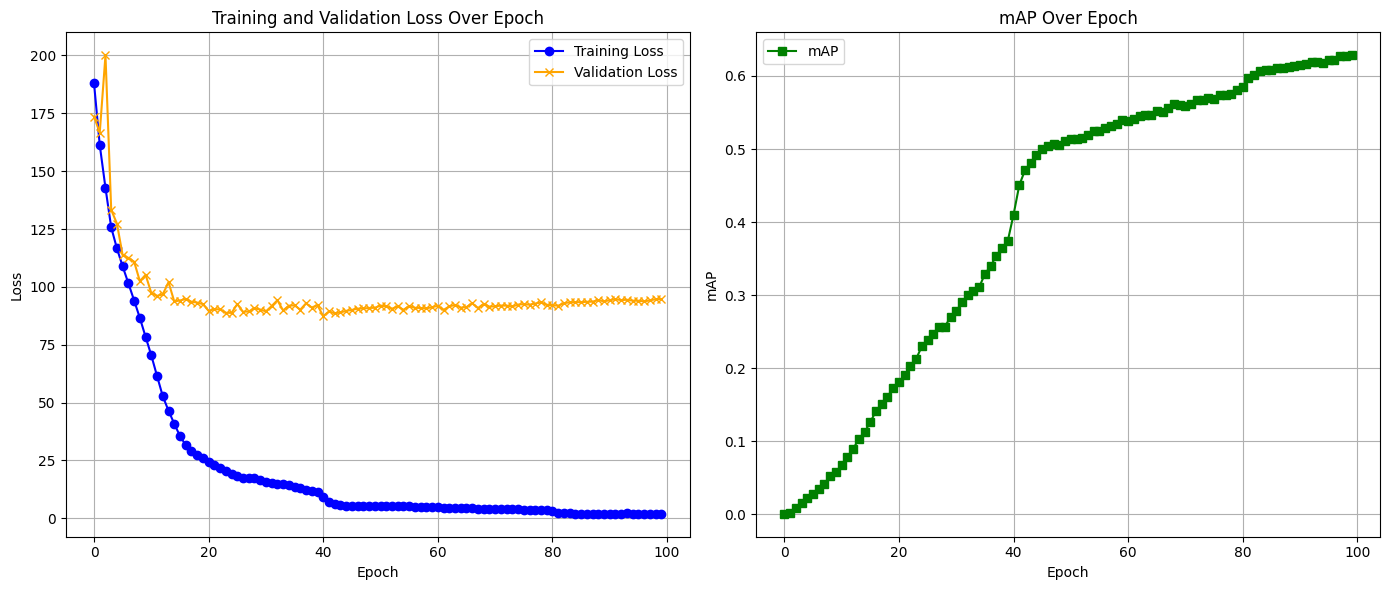

In [33]:
def get_latest_version(log_folder_path):
    versions = [
        int(folder.split("_")[-1])
        for folder in os.listdir(log_folder_path)
        if folder.startswith("version")
    ]
    latest_version = max(versions)
    return os.path.join(log_folder_path, f"version_{latest_version}")

# log_folder_path = get_latest_version("logs/lightning_logs/")
# print(f"Using log folder: {log_folder_path}")

# # Initialize dictionaries to store the logged values
# train_loss_data = {}
# val_loss_data = {}
# mAP_data = {}

# # Use TensorFlow's summary iterator to read the TensorBoard log file
# event_file = [
#     file for file in os.listdir(log_folder_path) if file.startswith("events")
# ][0]
# event_path = os.path.join(log_folder_path, event_file)

# epoch = None
# for e in tf.compat.v1.train.summary_iterator(event_path):
#     for v in e.summary.value:
#         if v.tag == "epoch":
#             epoch = int(v.simple_value)
#         elif v.tag == "avg_train_loss_per_epoch" and epoch is not None:
#             # train_loss_data[e.step] = v.simple_value
#             train_loss_data[epoch] = v.simple_value
#         elif v.tag == "avg_val_loss_per_epoch" and epoch is not None:
#             # val_loss_data[e.step] = v.simple_value
#             val_loss_data[epoch] = v.simple_value
#         elif v.tag == "avg_train_mAP_per_epoch" and epoch is not None:
#             # mAP_data[e.step] = v.simple_value
#             mAP_data[epoch] = v.simple_value

# # Convert data into lists sorted by steps
# steps_train = sorted(train_loss_data.keys())
# steps_val = sorted(val_loss_data.keys())
# steps_map = sorted(mAP_data.keys())

# train_loss_list = [train_loss_data[step] for step in steps_train]
# val_loss_list = [val_loss_data[step] for step in steps_val]
# mAP_list = [mAP_data[step] for step in steps_map]

# # Plot the logged information
# plt.figure(figsize=(14, 6))

# # Plot training and validation loss
# plt.subplot(1, 2, 1)
# plt.plot(
#     steps_train,
#     train_loss_list,
#     label="Training Loss",
#     color="blue",
#     linestyle="-",
#     marker="o",
# )
# plt.plot(
#     steps_val,
#     val_loss_list,
#     label="Validation Loss",
#     color="orange",
#     linestyle="-",
#     marker="x",
# )
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss Over Epoch")
# plt.legend()
# plt.grid(True)

# # Plot mAP
# plt.subplot(1, 2, 2)
# plt.plot(steps_map, mAP_list, label="mAP", color="green", linestyle="-", marker="s")
# plt.xlabel("Epoch")
# plt.ylabel("mAP")
# plt.title("mAP Over Epoch")
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

checkpoints\yolo-epoch=99-train_loss=1.10.ckpt


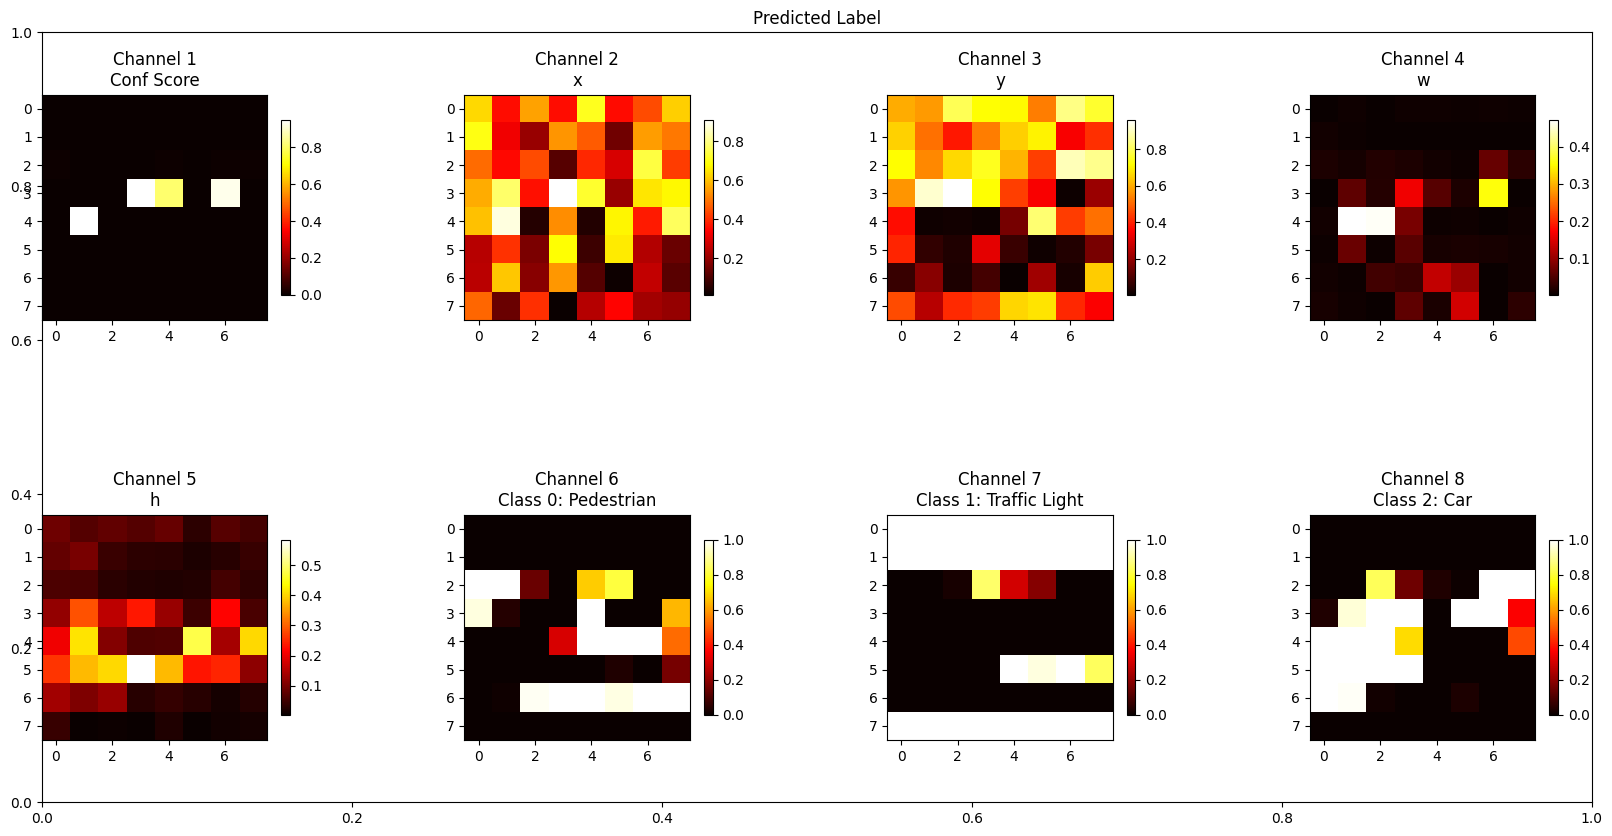

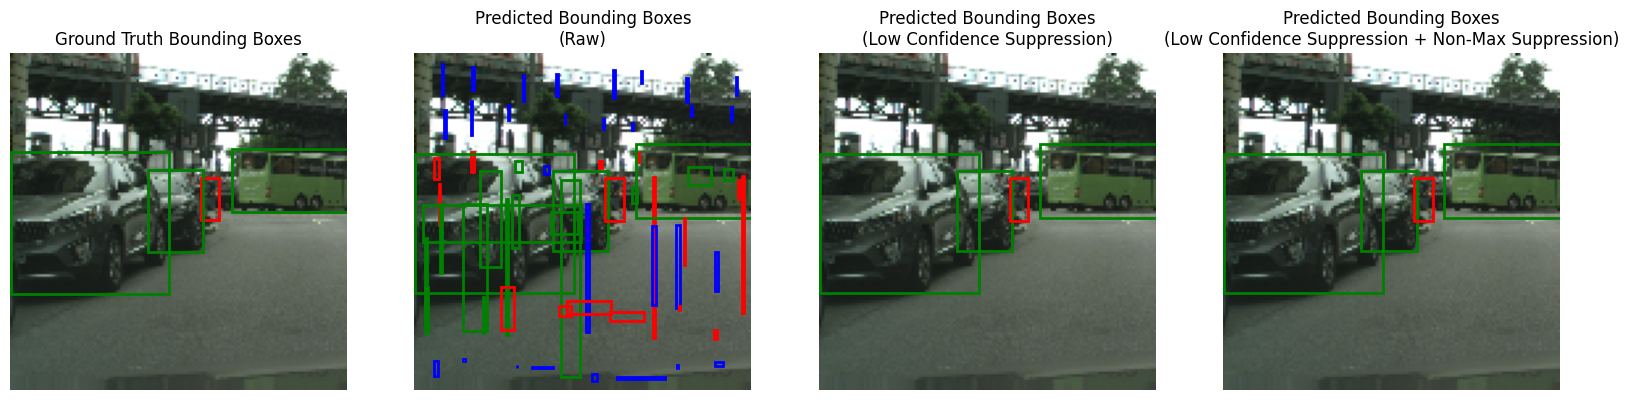

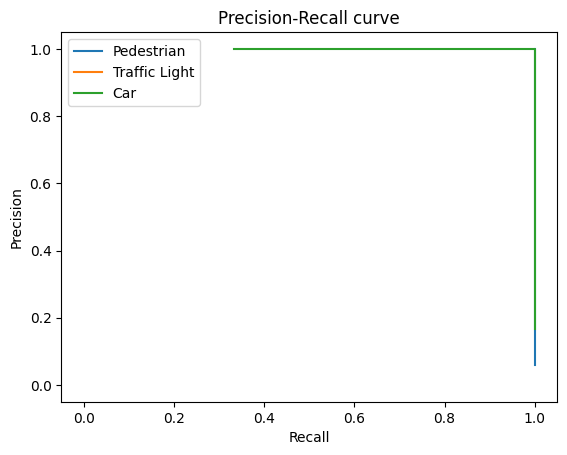

mAP: 0.11111111442248027


In [122]:
def infer_one_image(index=8):
    checkpoint_dir = "checkpoints/"
    latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
    if not latest_checkpoint:
        print("No checkpoint found. Please train the model first.")
        return

    print(latest_checkpoint)
    model = YOLO.load_from_checkpoint(latest_checkpoint)
    model.eval()

    test_image = images[index]
    test_label = raw_labels[index]
    test_label_processed = process_labels(np.array([test_label]))[0]
    # visualize_8x8x8(test_label_processed, title="Ground Truth Label")

    raw_output = model((torch.tensor(test_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0).to(device))
    output = raw_output.cpu().squeeze().detach().numpy()
    visualize_8x8x8(output, title="Predicted Label")

    output_label = reconstruct_raw_labels(np.array([output]), include_score=True)[0]

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    visualize_image(test_label, test_image, new_figure=False)
    plt.title("Ground Truth Bounding Boxes")
    plt.subplot(1, 4, 2)
    visualize_image(output_label, test_image, new_figure=False)
    plt.title("Predicted Bounding Boxes\n(Raw)")

    lcs_label = low_confidence_suppression(output_label)
    assert len(lcs_label) > 0, "All labels are filtered by LCS!"
    plt.subplot(1, 4, 3)
    visualize_image(lcs_label, test_image, new_figure=False)
    plt.title("Predicted Bounding Boxes\n(Low Confidence Suppression)")
    nms_label = non_max_suppression(lcs_label)
    plt.subplot(1, 4, 4)
    visualize_image(nms_label, test_image, new_figure=False)
    plt.title(
        "Predicted Bounding Boxes\n(Low Confidence Suppression + Non-Max Suppression)"
    )
    
    
    
    # plot precision_recall_curve on 3 class on the same plot
    predictions = [output_label]
    targets = [test_label]
    recall, precision = precision_recall_curve(predictions, targets, 0)
    plt.figure()
    plt.plot(recall, precision, label="Pedestrian")
    recall, precision = precision_recall_curve(predictions, targets, 1)
    plt.plot(recall, precision, label="Traffic Light")
    recall, precision = precision_recall_curve(predictions, targets, 2)
    plt.plot(recall, precision, label="Car")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend()
    
    plt.show()
    
    print(f"mAP: {mean_average_precision(predictions, targets)}")
    # print(yolo_loss(raw_output, torch.tensor(test_label_processed, dtype=torch.float32).unsqueeze(0).to(device)))

# infer_one_image(index=30)

checkpoints\yolo-epoch=99-train_loss=1.10.ckpt


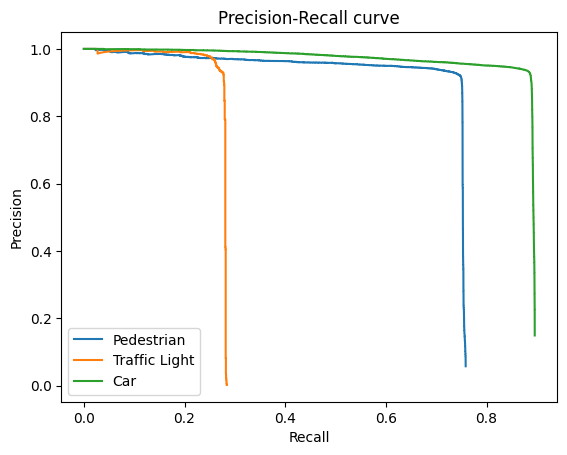

mAP: 0.6264445862688656


In [98]:
def infer():
    checkpoint_dir = "checkpoints/"
    latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
    if not latest_checkpoint:
        print("No checkpoint found. Please train the model first.")
        return

    print(latest_checkpoint)
    model = YOLO.load_from_checkpoint(latest_checkpoint)
    model.eval()

    labels = process_labels(raw_labels)
    full_dataset = YOLODataset(images, labels)
    test_loader = DataLoader(full_dataset)
    outputs = []
    targets = []
    for i, (x, y) in enumerate(test_loader):
        raw_output = model(x.to(device))
        output = raw_output.cpu().detach().numpy()[0]
        outputs.append(output)
        target = y.cpu().detach().numpy()[0]
        targets.append(target)

    outputs = np.array(outputs)
    targets = np.array(targets)
    outputs_reconstructed = reconstruct_raw_labels(outputs, include_score=True)
    targets_reconstructed = reconstruct_raw_labels(targets)

    # plot precision_recall_curve on 3 class on the same plot
    predictions = outputs_reconstructed
    targets = targets_reconstructed
    recall, precision = precision_recall_curve(predictions, targets, 0)
    plt.figure()
    plt.plot(recall, precision, label="Pedestrian")
    recall, precision = precision_recall_curve(predictions, targets, 1)
    plt.plot(recall, precision, label="Traffic Light")
    recall, precision = precision_recall_curve(predictions, targets, 2)
    plt.plot(recall, precision, label="Car")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend()
    plt.show()
    
    print(f"mAP: {mean_average_precision(predictions, targets)}")

# infer()

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

When comparing prediction confidence with ground truth confidence in the yolo_loss function, the ground truth confidence is pr(objectness)*IOU and the predicted confidence is just predictions[0]. However, we also multiplied predictions[0] by IOU. The model trained with this loss function outputs high confidence for all boxes, no matter correct or not. Another issue we had was that we applied the sigmoid function to every output channel, but we should only apply the sigmoid function to the first 5 channels and apply the sofmax function to the rest. This is because we want to clamp the information about bounding boxes within 0 and 1, and get classes probability distribution.

After we fixed the issue, our model achieved a decent performance. Our model is able to detect and bound cars with confidence over 0.8. The model also outputs bounding boxes for traffic lights with a confidence of around 0.5 and bounding boxes for pedestrians with a confidence of around 0.2. We then took a closer look at the dataset, there are more cars in the dataset compared to the other 2 classes. As the model has been trained more on cars, it is more familiar with cars, thus predicting with higher confidence. On the other hand, there are fewer traffic lights and pedestrians in the images. Pedestrians are also small, which makes detecting pedestrians even harder. One possible way to improve the performance is that we can train on more epochs, so that the model can see more objects in traffic light and pedestrian classes.

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output.

Please submit a pdf file alongside with the notebook, in colab, you can use "File -> Print (Ctrl+P)".

Your submission should include two files: this notebook and the pdf, but not trained model weights.

**Please comment out every training/ploting code, but only keep function definations, please do not modify the signature (name, parameters) of function defination.**

Please save before exporting!